In [24]:
from google.colab import drive
drive.mount('/content/gdrive')


ModuleNotFoundError: No module named 'google.colab'

In [1]:
import os
import cv2
import time
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization



print ('modules loaded')

modules loaded


##IMPORT LIBRARIES


##GET THE DATA






In [2]:
BATCH_SIZE = 16
df = pd.read_csv("F:/gp/Ocular_disease/Cataract/dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


##CREATE DATAFRAME CONTAINS THE PATH OF IMAGE AND IT'S LABEL




In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [4]:
def has_AMD(text):
    if "age-related macular degeneration" in text:
        return 1
    else:
        return 0
df["left_AMD"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_AMD(x))
df["right_AMD"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_AMD(x))
left_AMD = df.loc[(df.A ==1) & (df.left_AMD == 1)]["Left-Fundus"].values
print(left_AMD[:15])
right_AMD = df.loc[(df.A ==1) & (df.right_AMD == 1)]["Right-Fundus"].values
right_AMD[:15]


['43_left.jpg' '48_left.jpg' '53_left.jpg' '55_left.jpg' '102_left.jpg'
 '126_left.jpg' '136_left.jpg' '152_left.jpg' '158_left.jpg'
 '162_left.jpg' '164_left.jpg' '168_left.jpg' '178_left.jpg'
 '210_left.jpg' '212_left.jpg']


array(['43_right.jpg', '48_right.jpg', '53_right.jpg', '55_right.jpg',
       '71_right.jpg', '102_right.jpg', '126_right.jpg', '152_right.jpg',
       '153_right.jpg', '158_right.jpg', '160_right.jpg', '162_right.jpg',
       '164_right.jpg', '168_right.jpg', '178_right.jpg'], dtype=object)

In [5]:
print("Number of images in left AMD: {}".format(len(left_AMD)))
print("Number of images in right AMD: {}".format(len(right_AMD)))

Number of images in left AMD: 266
Number of images in right AMD: 285


In [6]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
print(right_normal[:15])
AMD = np.concatenate((left_AMD,right_AMD),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(AMD),len(normal))


['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
551 500


##CREATE DATAFRAME FOR THE OTHER TYPE OF DATA

In [7]:

dataset_dir = "F:/gp/Ocular_disease/AMD/dataset/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):

    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path)
            # Convert the image to grayscale

            # Create a kernel for the unsharp mask filter
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

            # Apply the unsharp mask filter
            unsharp = cv2.filter2D(image, -1, kernel)
            unsharp= crop_image_from_gray(unsharp)
            unsharp = cv2.resize(unsharp,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(unsharp),np.array(label)])
    random.shuffle(dataset)
    return dataset
        



In [8]:
dataset = create_dataset(AMD,1)
len(dataset)


100%|██████████| 551/551 [00:15<00:00, 36.53it/s]


551

In [9]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:28<00:00, 17.57it/s]


1051

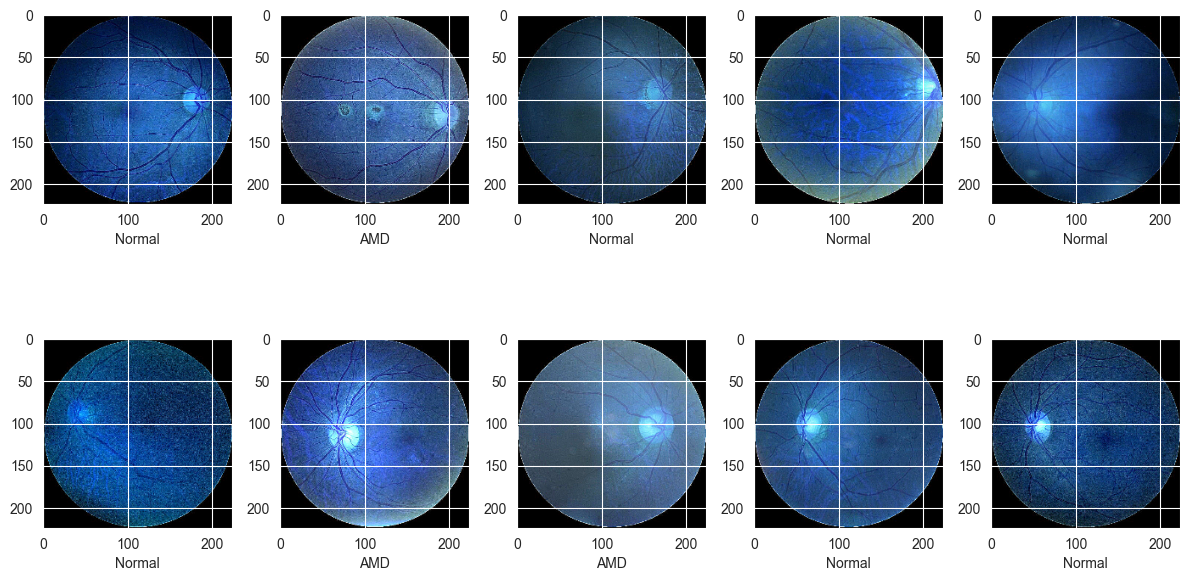

In [10]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "AMD"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

# Dividing dataset into x(features) & y(target)


In [11]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])



x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)


In [12]:

datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                            fill_mode='constant', cval=0.)
train_gen = datagen.flow(x_train, y_train, batch_size=32)

## Build the model <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [13]:
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


##FIT THE MODEL

In [14]:
import tensorflow as tf
from tensorflow.python.ops import histogram_ops


mc_filepath="/content/gdrive/MyDrive/gp/Cataract/callbacks/weights/weights-improvment-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc_callback = tf.keras.callbacks.ModelCheckpoint(mc_filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

csv_callback= tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/gp/Cataract/callbacks/my_train.csv',separator=',',append=False)
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/MyDrive/gp/Cataract/callbacks',histogram_freq=1,write_graph=True,write_images=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)

Epoch 1/50
27/27 [==============================] - 340s 13s/step - loss: 7.2525 - accuracy: 0.5435 - val_loss: 2.9245 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 362s 13s/step - loss: 2.5030 - accuracy: 0.6671 - val_loss: 2.8828 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 379s 14s/step - loss: 2.0763 - accuracy: 0.7047 - val_loss: 2.1496 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 403s 15s/step - loss: 1.5832 - accuracy: 0.7459 - val_loss: 2.1754 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 366s 14s/step - loss: 2.4191 - accuracy: 0.7024 - val_loss: 3.2679 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 363s 13s/step - loss: 1.6304 - accuracy: 0.7788 - val_loss: 1.8369 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 345s 13s/step - lo

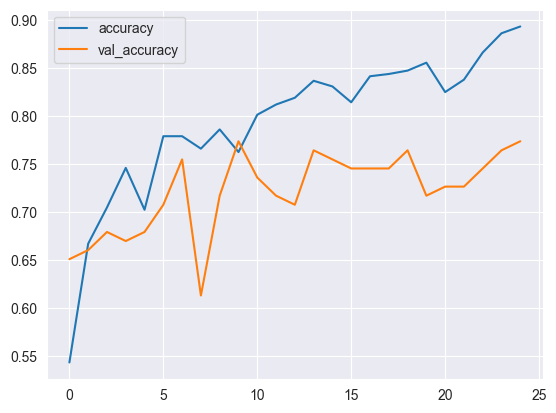

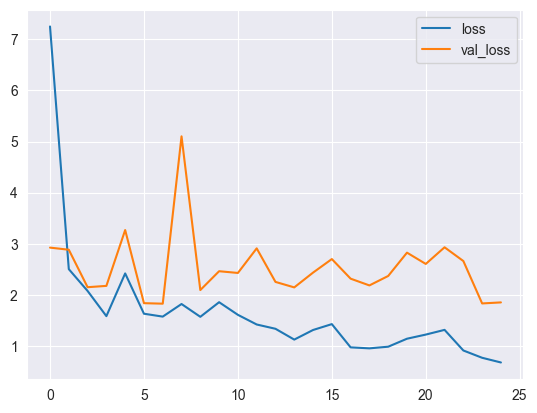

In [15]:

history = model.fit(train_gen,
                    batch_size=32, 
                    epochs=50,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(x_valid,y_valid),
                    verbose=1)


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

#EVALUATE THE MODEL

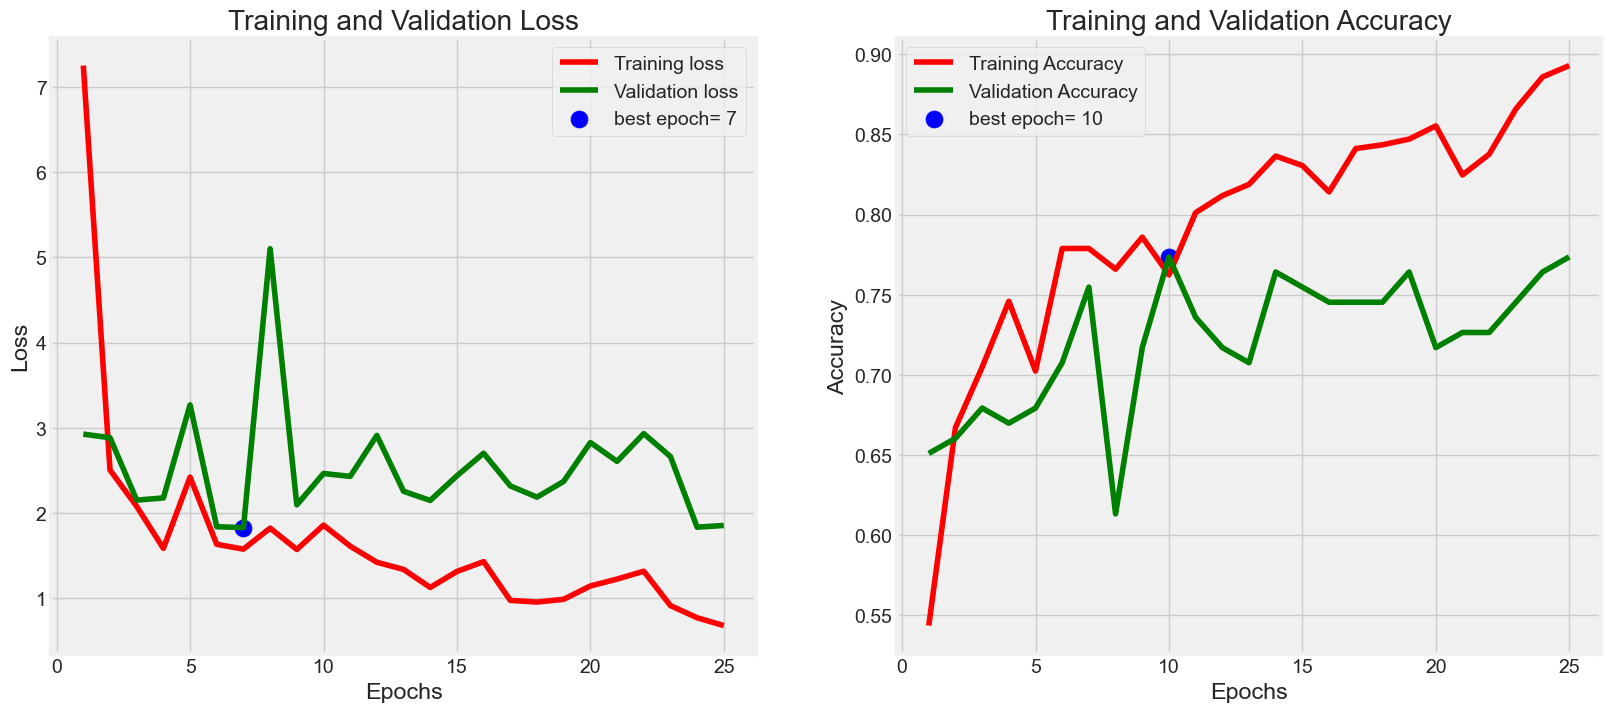

In [16]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

plot_training(history)

In [17]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

3/3 [==============================] - 30s 10s/step - loss: 1.9527 - accuracy: 0.7895
loss: 1.952723741531372
Accuracy: 0.7894737124443054


In [56]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)

3/3 [==============================] - 32s 10s/step


In [57]:
accuracy_score(y_test,y_pred.round())

0.8421052631578947

In [58]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84        43
           1       0.89      0.81      0.85        52

    accuracy                           0.84        95
   macro avg       0.84      0.85      0.84        95
weighted avg       0.85      0.84      0.84        95



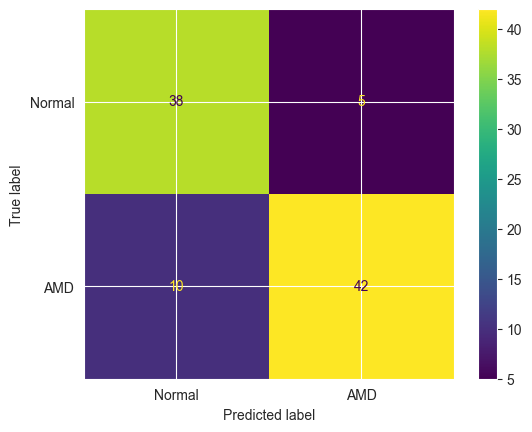

In [59]:

import numpy
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal","AMD"])

cm_display.plot()
plt.show()


##SAVE THE MODEL


In [61]:
model_name = 'VGG19'
subject = 'AMD_classification'
acc = accuracy * 100
save_path = 'F:/gp/Ocular_disease/AMD/saved_model'

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')


model was saved as F:/gp/Ocular_disease/AMD/saved_model\VGG19-AMD_classification-84.21.h5


#LOAD THE MODEL

In [63]:
import tensorflow as tf
Cataract_classification_model = tf.keras.models.load_model("F:/gp/Ocular_disease/AMD/saved_model/VGG19-AMD_classification-84.21.h5")
print(Cataract_classification_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
None


PREDICTION FUNCRION

In [69]:
import cv2
import numpy as np

image_size=224
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
        

def predict_class(image_path):


    image = cv2.imread(image_path)
    image= crop_image_from_gray(image)
    image = cv2.resize(image,(image_size,image_size))
    
    image=np.array(image)
    image=image.reshape(-1,image_size,image_size,3)

    y = Cataract_classification_model.predict([image])
    return y
prediction =predict_class("F:/gp/Ocular_disease/AMD/dataset/preprocessed_images/85_right.jpg")  
print(prediction[0][0])
if prediction[0][0] >0.45:
  print("AMD")
else:
  print("Normal")

1/1 [==============================] - 0s 369ms/step
4.0377373e-09
Normal
